# Convolutional Neural Networks

We covered Multi-layer Perceptrons (MLPs) in the last exercise. We now want to explore using `pytorch` for ML more. For this, we also will start looking into another popular network architecture called convolutional neural networks.

We start this exploration with a small motivating Gedankenexperiment.

## **Exercise 02.1** A MLP for my Phone

Take out your phone. Check in the picture galery some of the last images you took. Try to find out how many pixels such an image has! You should arrive with a tuple that denominates height and width of such an image.

Imagine you want to design an MLP network to categorize the pictures you took on your camera. We convert each image into a flat vector before feeding it into the network. We assume you like to use three hidden layers with 128 hidden neurons each. Then (for sake of the example) you want to predict a single category, i.e. your last layer has a size of 1. In this scenario, compute how many parameters such an MLP might have.

### 02.1 Solution

On my phone, I go to "Gallery", then select a picture. Then I "click" on properties (some phones call this information) and see that it has 2160 pixels in width and 3840 pixels in height (`2160x3840`). We ignore for the time being that most of these images are encoded as RGB or RGBA or even something else.

When such an image is flattened, it produces a vector of size `8294400`. For an MLP, every hidden neuron connects with every other hidden neuron. Thus, our MLP would be structured like this:

```
input (output shape: 8294400) -> hidden (output shape: 128) -> hidden (output shape: 128) -> hidden (output shape: 128) -> output (output shape: 1)
```
That means, that for the first hidden layer, we require $128 \cdot 8,294,400 = 1,061,683,200$ parameters. Every hidden layer consists of the weight matrix and a bias vector. The bias vector has the same size as the number of hidden neurons. With this information, we can calculate the number of parameters:

1. layer: $128 \cdot 8,294,400 = 1,061,683,200$ weights, $128$ bias terms, $1,061,683,200+128=1,061,683,328$ parameters
2. layer: $128 \cdot 128 = 16384$ weights, $128$ bias terms, $16384+128=16512$ parameters
3. layer: $128 \cdot 128 = 16384$ weights, $128$ bias terms, $16384+128=16512$ parameters
4. layer: $128 \cdot 1 = 128$ weights, $1$ bias term, $128+1=129$ parameters

In sum, this network would have $1061716481$ parameters. As each trainable parameter in a pytorch model is typically a `float32` number. This would result in the model to be of size $1,061,716,481 \cdot 4 \text{Byte} = 4,246,865,924 \text{Byte} \approx 3.9 \text{GiB} \approx 4.2 \text{GB}$. Such a model would already exceed some GPU's memory. So we better look for a way to have neural networks with a smaller number of parameters.

## A note on reproducibility

In the following code, we will rely a lot on [pseudorandom number generators](https://en.wikipedia.org/wiki/Pseudorandom_number_generator). They will not be too obvious, but play an important role. We will rely on them for:

- splitting the dataset
- shuffling the data during loading
- initializing the weights of our network

For didactical purposes, we fix the pseudorandomness to certain seed values (i.e. we fix the beginning of the random sequence). This will avoid more confusion than necessary when comparing results.

In [1]:

import numpy as np
import torch

np.random.seed(13)
torch.random.manual_seed(12)

## Loading 1D Training Data

To explore convolutions, we will start out considering a one dimensional sequence. The sequence will be taken from the [MNIST1D](https://github.com/greydanus/mnist1d) dataset. The advantage of this dataset is, that it is small and can serve well to demonstrate key concepts of machine learning.

<div style="display: block;margin-left: auto;margin-right: auto;width: 75%;"><img src="https://github.com/greydanus/mnist1d/raw/master/static/overview.png" alt="MNIST1D overview"></div>

In [2]:
from mnist1d.data import get_dataset_args, make_dataset

defaults = get_dataset_args()
data = make_dataset(defaults)
X, y = data['x'], data['y']

X.shape, y.shape, type(X), X.dtype, y.dtype

((4000, 40), (4000,), numpy.ndarray, dtype('float64'), dtype('int64'))

As we are interested in supervised learning, we rely on pairs of input data `X` and labels `y`. Here, the labels `y` refer to the number which each sequence in `X` resembles. Let's have a look at these sequences.

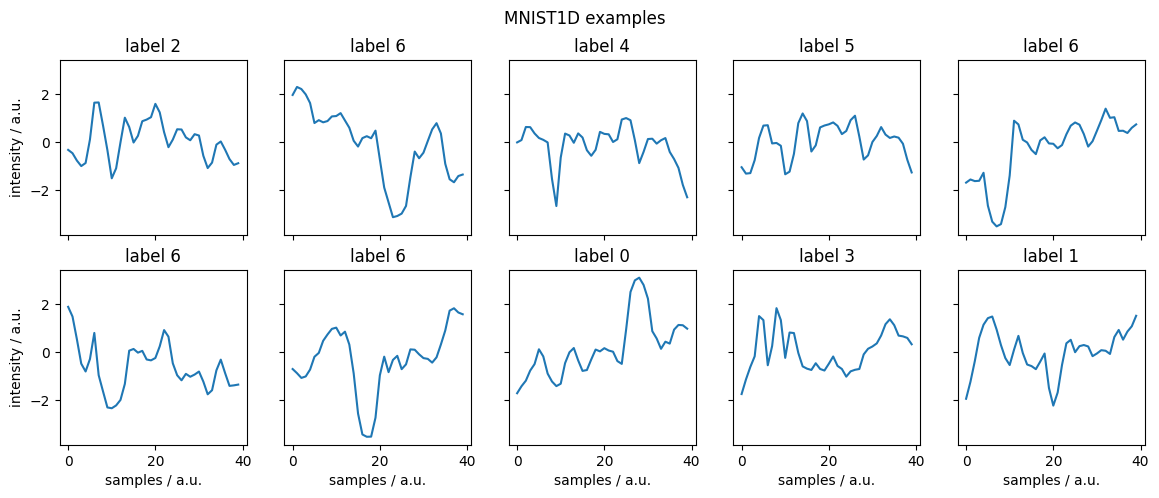

In [3]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(2, 5, figsize=(14, 5), sharex=True, sharey=True)

for sample in range(10):
    col = sample % 5
    row = sample // 5
    ax[row, col].plot(X[sample, ...])
    label = y[sample]
    ax[row, col].set_title(f"label {label}")
    if row == 1:
        ax[row, col].set_xlabel(f"samples / a.u.")
    if col == 0:
        ax[row, col].set_ylabel(f"intensity / a.u.")

f.suptitle("MNIST1D examples")
f.savefig("mnist1d_default_first10.svg")

You can tell from the above, that the signals are far from easy to distinguish. This gives rise for the need for a flexible network architecture. But let's not get ahead of ourselves. Before we dive into designing a network, we will have to create a dataloader first. In `pytorch`, having a `DataLoader` for your data is the first hurdle you have to overcome to get started.

In [4]:
from typing import Callable

import numpy as np
import torch
from sklearn.model_selection import train_test_split


class MNIST1D(torch.utils.data.Dataset):

    def __init__(self,
                 train:bool = True,
                 validation_size: float = 0.1,
                 mnist1d_args: dict = get_dataset_args(),
                 seed: int = 42):

        super().__init__()

        self.is_training = train
        self.data = make_dataset(mnist1d_args)

        # dataset split
        X_train, X_validation, y_train, y_validation = train_test_split(self.data['x'],
                                                            self.data['y'],
                                                            test_size=validation_size,
                                                            random_state=seed)

        # normalize the data only using information from the
        # training data to avoid data leakage!
        self.X_loc = np.min(X_train)
        self.X_scale = np.max(X_train) - np.min(X_train)

        # decide training and validationing
        if train:
            self.X = (X_train - self.X_loc)/self.X_scale
            self.y = y_train
        else:
            # use the same normalisation strategy as during training
            self.X = (X_validation - self.X_loc)/self.X_scale
            self.y = y_validation

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index: int):

        # [index:index+1] used instead of [index] to create a channel dimension in the front.
        # This is required by the convolutional layers we are going to use later on
        X = torch.from_numpy(self.X[index:index+1, ...].astype(np.float32))
        y = torch.from_numpy(self.y[index,...].astype(np.int64))

        return X, y

In `pytorch`, the Dataset class has to comply to 3 requirements:
- it has to inherit from torch.utils.data.Dataset
- it has to define a `__len__` function so that we can later call `len(mydataset)`
- it has to define a `__getitem__` function so that we can later call `mydataset[12]` to obtain sample 12
For more details, see the `pytorch` documentation on [Creating a Custom Dataset for your files](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) or [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

In [5]:
training_data = MNIST1D()
validation_data = MNIST1D(train=False)

nsamples = len(training_data)+len(validation_data)
assert nsamples == 4000, f"number of samples for MNIST1D is not 4000 but {nsamples}"

validationx, validationy = validation_data[12]
assert validationx.shape[-1] == 40, f"x shape should end with 40 but got:{validationx.shape}."
assert validationy.item() == 5, f"y should be 5 but got {validationy.item()}"
assert isinstance(validationx, torch.Tensor)
assert isinstance(validationy, torch.LongTensor)

In order to use the dataset for training, we need to create a DataLoader. A DataLoader orchestrates how the data is loaded and provided for the compute device that you intend to use. Note how we can set how many MNIST1D sequences at once will be provided to the compute device. This number, called the **batch size**, is set to `64` in the example below.

In [6]:
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)

train_X, train_y = next(iter(train_dataloader))
print("Batch of training data and labels with shapes",train_X.shape, train_y.shape)

Batch of training data and labels with shapes torch.Size([64, 1, 40]) torch.Size([64])


## Convolutions in 1D

Up until here, we have made great strides to load our dataset. We now want to explore what convolutions are and how to use them to construct a convolutional neural network (CNN).

A convolution is a mathematical operation. Here, we only consider convolutions on a discrete signal $x \in \mathbb{R}^{n}$ using a convolution kernel $w \in \mathbb{R}^{m}$ where $m << n$ usually. For a fixed index $i$ of the output vector $y$, a convolution of the signal $x$ with the kernel $w$, denoted as $y = x \ast w$ is defined by:
$$ y_{i} = \sum_{k=0}^{m-1} w_{k} \cdot x_{i+k}. $$

### Illustrated convolutions

For the convolution, the kernel $w$ is moved across the input signal $x$.

<div style="display: block;margin-left: auto;margin-right: auto;width: 75%;"><img src="img/02_1D_convolution_1o3.svg" alt="convolution 1/3"></div>

Usually, the length of the output signal is smaller than the size of the input signal when a convolution is applied. By padding the input signal with `0` values we can avoid this and ensure the output to be of the same size as the input. The above operation creates the first entry in the output $y$. Next, the kernel is moved one step further (the step size is called the `stride`).

<div style="display: block;margin-left: auto;margin-right: auto;width: 75%;"><img src="img/02_1D_convolution_2o3.svg" alt="convolution 2/3"></div>

With the operation above, we have now created the second entry in $y$. This operation is now repeated until the entire input sequence has operated upon.

<div style="display: block;margin-left: auto;margin-right: auto;width: 75%;"><img src="img/02_1D_convolution_3o3.svg" alt="convolution 3/3"></div>

Once the convolution has finished, we would expect something like the signal below:

<div style="display: block;margin-left: auto;margin-right: auto;width: 75%;"><img src="img/02_1D_convolution_done.svg" alt="convolution done"></div>

Key parameters of the convolution operation are:
- kernel size, i.e. the length of the kernel $w$
- the padding strategy, i.e. whether to pad with 0s or mirror the content or something else
- the padding width, i.e. how many entries to add to the signal left and right
- the stride, i.e. by which step size to move the kernel along the signal

There are more important parameters to define a convolution, but they are not relevant for our tutorial. For more details, see the definition of the [Conv1d](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html#torch.nn.Conv1d) operation in `pytorch`.

## A Convolutional Neural Network

We will now construct a model in Pytorch. The setup has to comply to some rules. But let's dive in first.

In [7]:
class MyCNN(torch.nn.Module):

    def __init__(self, nlayers: int = 3, nchannels=16):

        super().__init__()
        self.layers = torch.nn.Sequential()

        # convolve and shrink input width by 2x
        self.layers.append(torch.nn.Conv1d(in_channels=1, out_channels=nchannels,
                                           kernel_size=5, padding=2, stride=2))
        self.layers.append(torch.nn.ReLU())

        # convolve and shrink input width by 2x
        self.layers.append(torch.nn.Conv1d(in_channels=nchannels, out_channels=nchannels,
                                           kernel_size=5, padding=2, stride=2))
        self.layers.append(torch.nn.ReLU())

        # convolve and keep input width
        self.layers.append(torch.nn.Conv1d(in_channels=nchannels, out_channels=nchannels,
                                           kernel_size=3, padding=1))
        self.layers.append(torch.nn.ReLU())

        # flatten and add a linear tail (an MLP like in the first tutorial)
        self.layers.append(torch.nn.Flatten())
        self.layers.append(torch.nn.Linear(nchannels*10,10))

        # NOTE: we do not apply the softmax activation here for reasons that will
        # become clear just a bit later.
        # self.layers.append(torch.nn.Softmax(dim=-1)) # to produce class probabilities

        nparams = self.count_params()
        print(f"initialized CNN with {nparams} parameters")

    def forward(self, x):

        return self.layers(x)

    def count_params(self):

        return sum([p.numel() for p in self.parameters() if p.requires_grad])

Again, the model definition above has to comply to some rules:
- the model has to inherit from `torch.nn.Module`
- the model has to implement `__init__`
- the model has to implement a `forward` function
We can check that we have implemented the model "correctly", but just passing in some data. All weights are initialized randomly by default.

In [8]:
model = MyCNN(nchannels=32) # construct the model

initialized CNN with 11658 parameters


In [9]:
with torch.no_grad():
    output = model(train_X) # perform a forward pass (note the __call__ method is automatically using the forward function)
print(output.shape)

torch.Size([64, 10])


## **Exercise 02.2** How does my model look like?

When designing a model, it can be very easy to loose track of what you are doing. In this exercise, we want to explore how to inspect models. `torch` only has one built-in way to display the structure of a model. Try the following code:

`print(model)`

Doing so can also serve as another first validation, if you have implemented the model with respect to python syntax correctly.

In [10]:
# Solution 02.2
print(model)

MyCNN(
  (layers): Sequential(
    (0): Conv1d(1, 32, kernel_size=(5,), stride=(2,), padding=(2,))
    (1): ReLU()
    (2): Conv1d(32, 32, kernel_size=(5,), stride=(2,), padding=(2,))
    (3): ReLU()
    (4): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=320, out_features=10, bias=True)
  )
)


## **Exercise 02.3** More than just __repr__!

Printing a model is nice and provides a first glance at the structure of your architecture. In practice however, there is one more thing that is crucial in designing a torch model. You will notice with time how essential it is to understand how data flows through a model! For this, `torch` does **NOT** have built-in methods.

At the time of writing, there is a nice library called `torchinfo` available on [github](https://github.com/TylerYep/torchinfo) and [pypi](https://pypi.org/project/torchinfo/). Your task is to install this library and run the summary function with the `model` above.

Solution 02.3, install the library if not present already

Run the following code in a cell to install the `torchinfo` package:
``` bash
python -m pip install torchinfo
```

In [11]:
# Solution 02.3, second use the library
from torchinfo import summary

summary(model, input_size=train_X.shape)

Layer (type:depth-idx)                   Output Shape              Param #
MyCNN                                    [64, 10]                  --
├─Sequential: 1-1                        [64, 10]                  --
│    └─Conv1d: 2-1                       [64, 32, 20]              192
│    └─ReLU: 2-2                         [64, 32, 20]              --
│    └─Conv1d: 2-3                       [64, 32, 10]              5,152
│    └─ReLU: 2-4                         [64, 32, 10]              --
│    └─Conv1d: 2-5                       [64, 32, 10]              3,104
│    └─ReLU: 2-6                         [64, 32, 10]              --
│    └─Flatten: 2-7                      [64, 320]                 --
│    └─Linear: 2-8                       [64, 10]                  3,210
Total params: 11,658
Trainable params: 11,658
Non-trainable params: 0
Total mult-adds (M): 5.74
Input size (MB): 0.01
Forward/backward pass size (MB): 0.66
Params size (MB): 0.05
Estimated Total Size (MB): 0.72

## Classification with a CNN

CNNs have become extremely popular to use for classification tasks. A classification tries to categorize or classify a given input signal to a fixed number of possible outcomes. In our case, these outcomes are the class labels of MNIST1D. For this reason, we can call our model a classifier now. We have to create an optimizer that takes care of updating the model parameters in a smart way exploiting the gradients of the loss function. We use `AdamW` with default options for the time being. Note, to construct the optimizer, we have to provide all parameters of our model in the constructor so it knows which parameters to adjust.

In [12]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)

As a next step, we have to consider the loss function. To do so, we will use the CrossEntropyLoss.

According to the documentation, this loss functions expects predictions to be unnormalized "logits" and internally applies the softmax activation to obtain class probabilities in a numerically efficient way. This is the reason why our model did not include this activation in the forward step.


In [13]:
criterion = torch.nn.CrossEntropyLoss() # our loss function

We are now ready to code up our training loop.

In [14]:
from sklearn.metrics import accuracy_score as accuracy

max_epochs = 60
log_every = 5
results = {'train_losses':[], 'validation_losses': [],'train_acc': [], 'validation_acc':[]}

# containers for results per epoch
ntrainsteps = len(train_dataloader)
train_acc, train_loss = torch.zeros((ntrainsteps,)), torch.zeros((ntrainsteps,))
nvalidationsteps = len(validation_dataloader)
validation_acc, validation_loss = torch.zeros((nvalidationsteps,)), torch.zeros((nvalidationsteps,))

for epoch in range(max_epochs):
    model.train()
    # perform training for one epoch
    for idx, (X, y) in enumerate(train_dataloader):

        # forward pass
        y_hat = model(X)

        # compute loss
        loss = criterion(y_hat, y)

        # compute gradient
        loss.backward()

        # apply weight update rule
        optimizer.step()

        # set gradients to 0
        optimizer.zero_grad()

        # compute metrics for monitoring
        # NOTE: as the model does not apply the softmax, we need to do it here
        y_hat_class = y_hat.softmax(-1).argmax(-1)
        acc = accuracy(y.cpu().numpy(),
                       y_hat_class.cpu().numpy())

        train_loss[idx] = loss.item()
        train_acc[idx] = acc

    model.eval()
    with torch.no_grad():
        for idx, (X_validation, y_validation) in enumerate(validation_dataloader):
            y_hat_validation = model(X_validation)
            loss_ = criterion(y_hat_validation, y_validation)

            y_hat_validation_class = y_hat_validation.softmax(-1).argmax(-1)
            acc = accuracy(y_validation.cpu().numpy(),
                        y_hat_validation_class.cpu().numpy())
            validation_loss[idx] = loss_.item()
            validation_acc[idx] = acc

    results['train_losses'].append(train_loss.mean())
    results['train_acc'].append(train_acc.mean())
    results['validation_losses'].append(validation_loss.mean())
    results['validation_acc'].append(validation_acc.mean())

    if epoch % log_every == 0 or (epoch+1) == max_epochs:
        print(f"{epoch+1}/{max_epochs} :: training loss {train_loss.mean()} accuracy {train_acc.mean()}; validation loss {validation_loss.mean()} accuracy {validation_acc.mean()}")

1/60 :: training loss 2.285392999649048 accuracy 0.13103070855140686; validation loss 2.163808822631836 accuracy 0.1785714328289032
6/60 :: training loss 1.3918355703353882 accuracy 0.43585526943206787; validation loss 1.3380622863769531 accuracy 0.4285714328289032
11/60 :: training loss 1.142801284790039 accuracy 0.5490679740905762; validation loss 1.1310046911239624 accuracy 0.53125
16/60 :: training loss 1.0094672441482544 accuracy 0.5989583134651184; validation loss 1.1354320049285889 accuracy 0.5357142686843872
21/60 :: training loss 0.884005606174469 accuracy 0.6496710777282715; validation loss 1.0586262941360474 accuracy 0.59375
26/60 :: training loss 0.8246967196464539 accuracy 0.6770833134651184; validation loss 0.9853021502494812 accuracy 0.6138392686843872
31/60 :: training loss 0.6755204200744629 accuracy 0.7327302694320679; validation loss 0.828048050403595 accuracy 0.6919642686843872
36/60 :: training loss 0.5612140893936157 accuracy 0.7741228342056274; validation loss 0.

You can tell from the above that pytorch is yet a very low level library. You have to code up the training for-loop yourself. This is in contrast to other libraries like [keras](https://keras.io), [pytorch-lightning](https://lightning.ai/docs/pytorch/stable/) or [scikit-learn](https://scikit-learn.org). These libraries provide you with complete "Trainer" or model-like objects which in turn offer a `.fit` method to start training. Decide on your own which suits your time budget, requirements and taste better.

## **Exercise 02.4** Learning Curves

Use the `results` object to plot the loss curves of your model! This is often a helpful visualisation to judge if longer training will make sense or to discover overfitting.

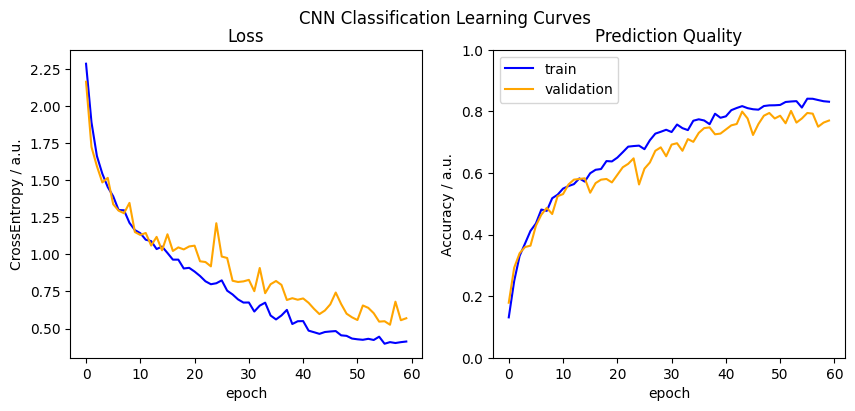

In [15]:
# Solution 02.4
f, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

# losses
ax[0].plot(results['train_losses'],color="b",label="train")
ax[0].plot(results['validation_losses'],color="orange",label="validation")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("CrossEntropy / a.u.")
ax[0].set_title("Loss")

# accuracy
ax[1].plot(results['train_acc'],color="b",label="train")
ax[1].plot(results['validation_acc'],color="orange",label="validation")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("Accuracy / a.u.")
ax[1].set_ylim(0.,1.)
ax[1].set_title("Prediction Quality")
ax[1].legend()

f.suptitle("CNN Classification Learning Curves")
f.savefig("mnist1d_classification_learning_curve.svg")